### 라이브러리 임포트

In [1]:
import os
import numpy as np
import pandas as pd
import torch
import torchvision
import cv2
import random
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
from torch.utils.data import DataLoader

In [2]:
torch.__version__

'2.3.1'

In [3]:
torchvision.__version__

'0.18.1'

### 경로 설정
 - 현재 폴더 경로를 찾기
 - 슬관절 데이터가 전부 담긴 폴더 찾기
 - 하위 폴더 경로를 각각 변수에 저장

In [4]:
os.getcwd()

'c:\\Users\\Harvey\\Desktop\\Codes\\Python\\practice'

In [5]:
base_dir = os.getcwd() + '\\data\\datasets\\osteoarthritis'

train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

In [6]:
test_dir

'c:\\Users\\Harvey\\Desktop\\Codes\\Python\\practice\\data\\datasets\\osteoarthritis\\test'

In [7]:
os.listdir(base_dir)[1:]

os.listdir(os.path.join(train_dir,'0'))

['9001695L.png',
 '9001695L_br.png',
 '9001695L_clahe.png',
 '9001695L_no.png',
 '9001897L.png',
 '9001897L_br.png',
 '9001897L_clahe.png',
 '9001897L_no.png',
 '9003126L.png',
 '9003126L_br.png',
 '9003126L_clahe.png',
 '9003126L_no.png',
 '9003126R.png',
 '9003126R_br.png',
 '9003126R_clahe.png',
 '9003126R_no.png',
 '9003430L.png',
 '9003430L_br.png',
 '9003430L_clahe.png',
 '9003430L_no.png',
 '9003658L.png',
 '9003658L_br.png',
 '9003658L_clahe.png',
 '9003658L_no.png',
 '9003658R.png',
 '9003658R_br.png',
 '9003658R_clahe.png',
 '9003658R_no.png',
 '9004315L.png',
 '9004315L_br.png',
 '9004315L_clahe.png',
 '9004315L_no.png',
 '9004315R.png',
 '9004315R_br.png',
 '9004315R_clahe.png',
 '9004315R_no.png',
 '9004669L.png',
 '9004669L_br.png',
 '9004669L_clahe.png',
 '9004669L_no.png',
 '9004669R.png',
 '9004669R_br.png',
 '9004669R_clahe.png',
 '9004669R_no.png',
 '9005075L.png',
 '9005075L_br.png',
 '9005075L_clahe.png',
 '9005075L_no.png',
 '9005075R.png',
 '9005075R_br.png',
 '9

### 폴더 경로를 활용해서 이미지 불러오기, 라벨링 하기
 - 폴더 구조를 보면 훈련세트, 검증세트, 테스트 세트가 분리되어 있고 하위 폴더에 KL등급(0~4)별로 폴더가 있고 그 안에 이미지가 있음
 - 따라서, 이미지-KL등급을 한 묶음으로 데이터 구조를 만들예정 ex) [[이미지데이터, kl등급]] -> [[(224*224)의 이미지 데이터 행렬, 0],...]
 - 라벨링은 폴더명 자체를 활용하여 등급을 매길 예정

In [8]:
def load_dataset(base_dir):
    dataset_all =  {} # 전체 데이터를 담을 딕셔너리
    
    # 훈련, 검증, 테스트 폴더 별로 데이터를 하나씩 불러올 예정
    folder_list = os.listdir(base_dir)[1:] # auto-test 폴더는 제외
    
    for folder in folder_list:
        dataset = [] # 훈련, 검증, 테스트 별 정보를 담을 리스트
        split_folder = os.path.join(base_dir, folder) # 현재 작업할 폴더
        # print('cur1 : ',split_folder)
        labels = os.listdir(split_folder) # 각 등급별로 폴더 확인 ['0', '1', '2', '3', '4']
        for label in labels:
            current_folder = f'{split_folder}\\{label}'
            # print('cur2 :',current_folder)
            file_list = os.listdir(current_folder) # 현재 폴더에 있는 파일 불러오기
            for file in file_list:
                file_info = {} # 이미지 경로와, 라벨링 값을 담을 딕셔너리
                file_info['file_path'] = os.path.join(current_folder, file)
                file_info['class'] = int(label)
                dataset.append(file_info)
        dataset_all[folder] = dataset
        
    return dataset_all
    

In [9]:
dataset = load_dataset(base_dir)

### 데이터 정보 확인

In [10]:
print(len(dataset['train']), len(dataset['val']), len(dataset['test']))
print(dataset['train'][0])

23112 3304 1656
{'file_path': 'c:\\Users\\Harvey\\Desktop\\Codes\\Python\\practice\\data\\datasets\\osteoarthritis\\train\\0\\9001695L.png', 'class': 0}


In [11]:
df = pd.DataFrame(dataset['train'])
df['class'].value_counts()

class
0    9144
2    6064
1    4184
3    3028
4     692
Name: count, dtype: int64

<Axes: xlabel='class', ylabel='count'>

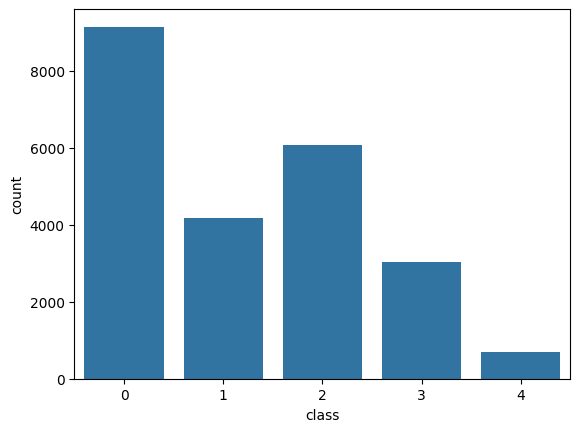

In [12]:
sns.countplot(x='class', data=df)

### 데이터 가져오기

### 랜덤으로 데이터 가져오기
 - pandas 데이터 프레임에서 각 등급별로 5개씩만 추출해보고 인덱스를 저장한 후 출력


In [13]:
# 등급별로 랜덤으로 5개씩 뽑아오기

SAMPLE_SIZE = 5
labels = df['class'].unique()
rand_idx = []
for label in labels:
    idx_list = df.groupby('class').get_group(label).sample(SAMPLE_SIZE).index.astype(int)
    rand_idx.append(idx_list)
    
rand_idx # 0등급부터 차례대로 5개씩 인덱스가 저장되어있음
    

[Index([6697, 3553, 3579, 3683, 6562], dtype='int32'),
 Index([12912, 11690, 13103, 9812, 9810], dtype='int32'),
 Index([17818, 16391, 17224, 15506, 18848], dtype='int32'),
 Index([21724, 19990, 19537, 21054, 20559], dtype='int32'),
 Index([23106, 22458, 22449, 22970, 22721], dtype='int32')]

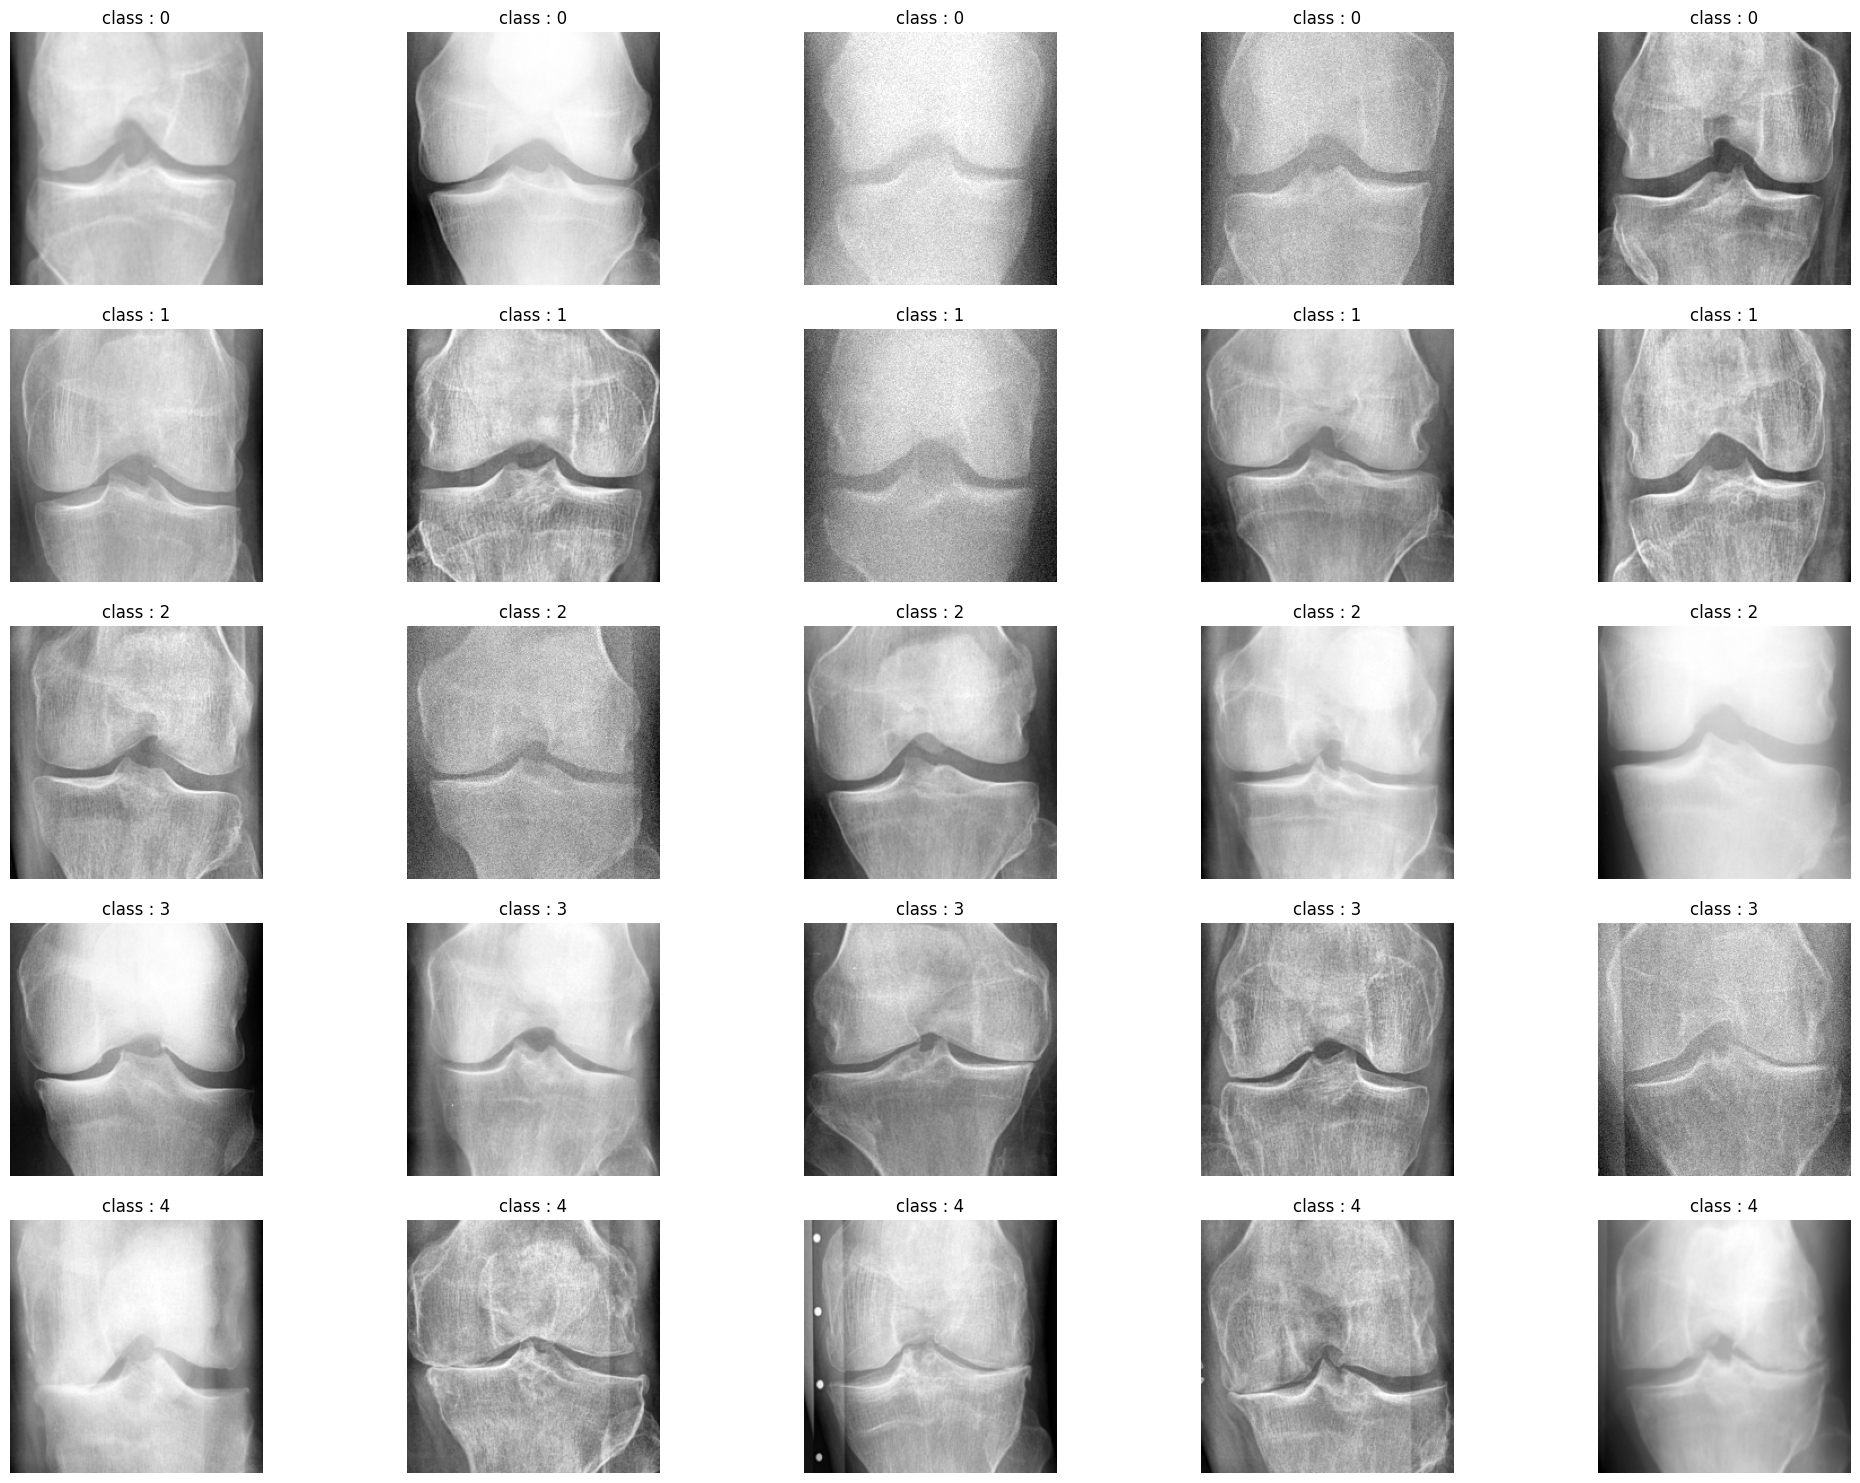

In [14]:
fig, axs = plt.subplots(5, 5, figsize=(20, 15)) # 5 x 5 형태로 출력
plt.tight_layout()

for ax, indice in zip(axs, rand_idx): # 훈련 데이터중 등급별로 5개씩 불러와보기 
    for i, idx in enumerate(indice): # 1줄에 5개씩 출력
        img = cv2.imread(dataset['train'][idx]['file_path'], cv2.IMREAD_GRAYSCALE) # 이미지 경로를 이용해 이미지를 흑백으로 불러오고 img변수에 저장
        ax[i].imshow(img, cmap='gray')
        ax[i].set_title(f"class : {dataset['train'][idx]['class']}") # 
        ax[i].axis(False)

### 데이터 이미지 전처리 함수 만들어보기
 - x-ray 데이터는 히스토그램 평활화 기법을 이용해서 대비를 증가 시킴
 - HEQ(Histogram EQualization)
 - AHE(Adaptive Histogram Equalization)
 - CLAHE(Contrast Limited Adaptive Histogram Equalization)

In [15]:
def check_image_preprocessing(image_path):
    
    # 원본 이미지
    origin_img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    # origin_img = cv2.resize(origin_img, (96, 96))
    rows, cols = origin_img.shape[:2]
    hist = cv2.calcHist([origin_img], [0], None, [256], [0, 256])
    
    # HEQ 적용
    processed_img = cv2.equalizeHist(origin_img)
    hist2 = cv2.calcHist([processed_img], [0], None, [256], [0, 256])
    
    # CLAHE 적용
    clahe = cv2.createCLAHE(clipLimit=2.5, tileGridSize=(8, 8))
    clahe_img = clahe.apply(origin_img)
    hist3 = cv2.calcHist([clahe_img], [0], None, [256], [0, 256])
    
    # 가우시안 블러 적용
    blur_img = cv2.GaussianBlur(origin_img, (3, 3), sigmaX=1, sigmaY=1)
    hist4 = cv2.calcHist([blur_img], [0], None, [256], [0, 256])
    
    # 이미지랑 밝기 분포 확인
    plt.figure(figsize=(20, 10))
    plt.subplot(2, 4, 1)
    plt.imshow(origin_img, cmap='gray')
    plt.title('origin_image')
    plt.subplot(2, 4, 2)
    plt.title('equailized_image')
    plt.imshow(processed_img, cmap='gray')
    plt.subplot(2, 4, 3)
    plt.title('CLAHE_image')
    plt.imshow(clahe_img, cmap='gray')
    plt.subplot(2, 4, 4)
    plt.title('Blur_image')
    plt.imshow(blur_img, cmap='gray')
    plt.subplot(2, 4, 5)
    plt.title('origin_hist')
    plt.plot(hist)
    plt.subplot(2, 4, 6)
    plt.plot(hist2)
    plt.title('equilzed_hist')
    plt.subplot(2, 4, 7)
    plt.plot(hist3)
    plt.title('CLAHE_hist')
    plt.subplot(2, 4, 8)
    plt.plot(hist4)
    plt.title('Blur_hist')
    

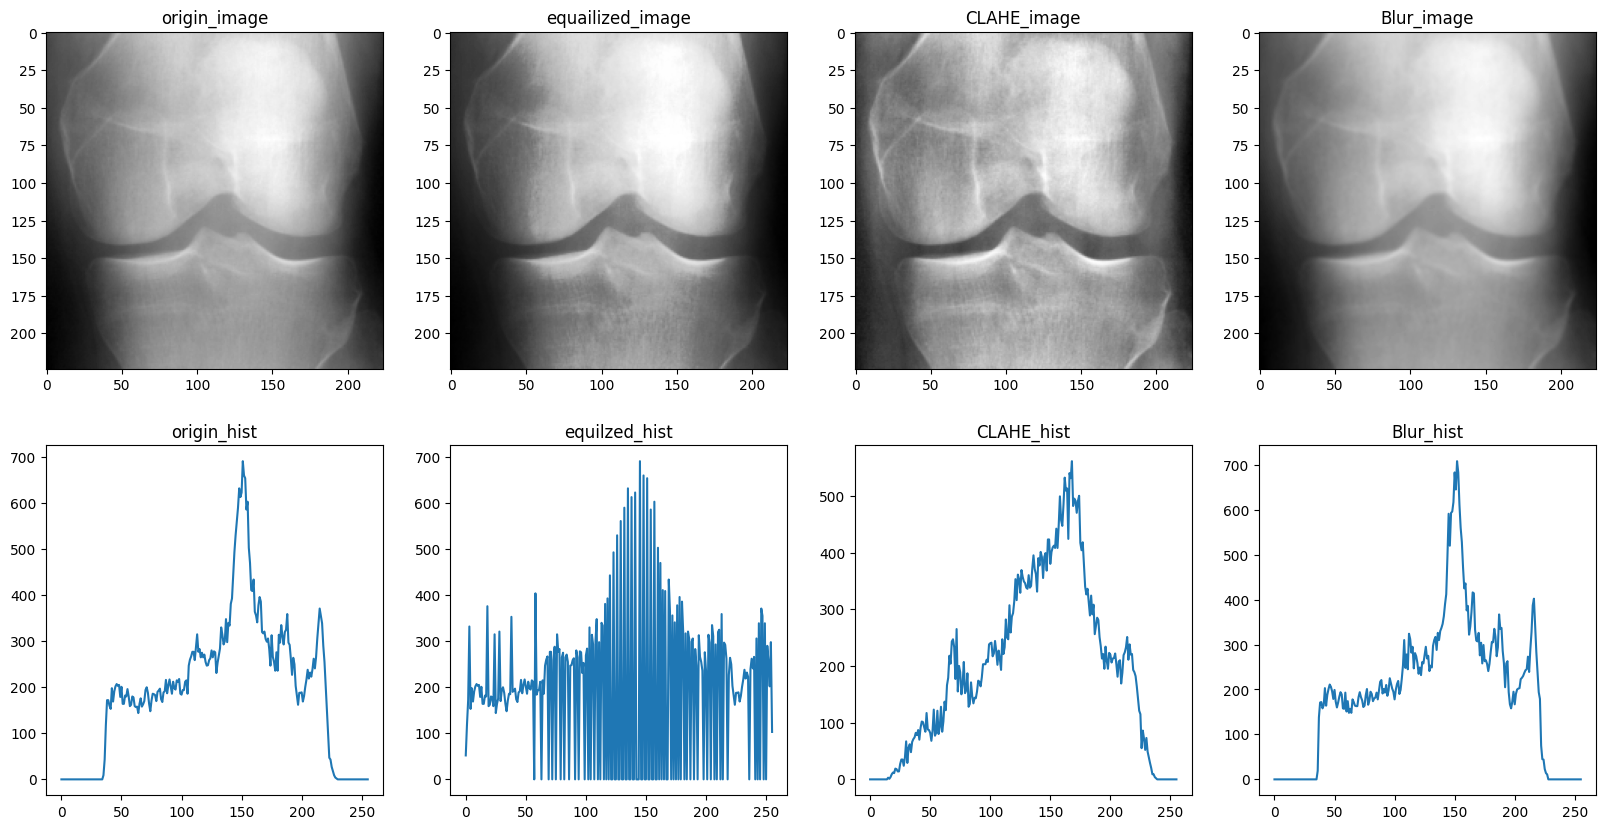

In [16]:
check_image_preprocessing(dataset['train'][0]['file_path'])

### 데이터 증강하기
 - 기존 데이터셋은 좌우대칭(flip)만 있음(L, 또는 R로 끝남)
 - 노이즈 추가, 랜덤으로 블러링 한 경우를 추가함

In [17]:
def make_noise(img, std=10):
    height, width = img.shape
    noise = np.zeros_like(img, dtype='float')
    for i in range(height):
        for j in range(width):
            ran_noise = np.random.normal()
            set_noise = std * ran_noise
            noise[i][j] = img[i][j] + set_noise
 
    return noise           

In [18]:
os.listdir(base_dir)

['auto_test', 'test', 'train', 'val']

In [19]:
# 증강함수는 실행하지마세요
# def data_augmentation(base_dir):
    
#     folder_list = ['train', 'val'] # 훈련, 검증 데이터만 증강
    
#     for folder in folder_list:
#         split_folder = os.path.join(base_dir, folder) # 현재 작업할 폴더
#         labels = os.listdir(split_folder) # 각 등급별로 폴더 확인 ['0', '1', '2', '3', '4']
#         for label in labels: 
#             current_folder = f'{split_folder}\\{label}'
#             file_list = os.listdir(current_folder) # 현재 폴더에 있는 파일 불러오기
#             # print(current_folder)
#             for file in file_list:
#                 file_path = os.path.join(current_folder, file)
#                 origin_img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
#                 randblur = random.uniform(0, 1)
#                 blur_img = cv2.GaussianBlur(origin_img, (5, 5), sigmaX=randblur, sigmaY=randblur)
#                 # noise image
#                 noise_img = make_noise(origin_img)
#                 clahe = cv2.createCLAHE(clipLimit=2.5, tileGridSize=(8, 8))
#                 clahe_img = clahe.apply(origin_img)
#                 cv2.imwrite(current_folder + '\\' + file.split('.')[0]+'_br.png', blur_img)
#                 cv2.imwrite(current_folder + '\\' + file.split('.')[0]+'_no.png', noise_img)
#                 cv2.imwrite(current_folder + '\\' + file.split('.')[0]+'_clahe.png', clahe_img)

In [20]:
# data_augmentation(base_dir)

### 증강된 데이터 확인

In [21]:
data = load_dataset(base_dir)
print(len(data['train']), len(data['val']), len(data['test']))
print(data['train'][0:3])

23112 3304 1656
[{'file_path': 'c:\\Users\\Harvey\\Desktop\\Codes\\Python\\practice\\data\\datasets\\osteoarthritis\\train\\0\\9001695L.png', 'class': 0}, {'file_path': 'c:\\Users\\Harvey\\Desktop\\Codes\\Python\\practice\\data\\datasets\\osteoarthritis\\train\\0\\9001695L_br.png', 'class': 0}, {'file_path': 'c:\\Users\\Harvey\\Desktop\\Codes\\Python\\practice\\data\\datasets\\osteoarthritis\\train\\0\\9001695L_clahe.png', 'class': 0}]


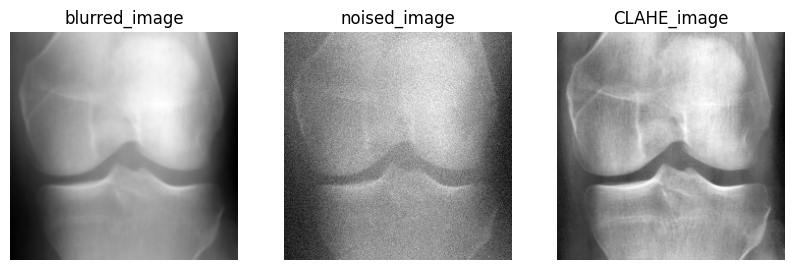

In [22]:
br_img = cv2.imread(os.path.join(train_dir, '0\\9001695L_br.png'), cv2.IMREAD_GRAYSCALE)
no_img = cv2.imread(os.path.join(train_dir, '0\\9001695L_no.png'), cv2.IMREAD_GRAYSCALE)
clahe_img = cv2.imread(os.path.join(train_dir, '0\\9001695L_clahe.png'), cv2.IMREAD_GRAYSCALE)
plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.imshow(br_img, cmap='gray')
plt.axis(False)
plt.title('blurred_image')
plt.subplot(1, 3, 2)
plt.title('noised_image')
plt.imshow(no_img, cmap='gray')
plt.axis(False)
plt.subplot(1, 3, 3)
plt.title('CLAHE_image')
plt.imshow(clahe_img, cmap='gray')
plt.axis(False)
plt.show()

### 훈련 데이터셋 만들기

In [23]:
transform = torchvision.transforms.Compose([torchvision.transforms.Resize((128, 128)), # 224 * 224 * 3채널 -> 128 * 128
                                            # torchvision.transforms.Grayscale(1), # 1채널의 흑백으로 변경                                            
                                            torchvision.transforms.ToTensor(), # tensor로 자료형 변환
                                            torchvision.transforms.Normalize([0.6058561,0.6058561,0.6058561], [0.15344825, 0.15344825, 0.15344825])
                                            ])
# 각 데이터 별로 적용
train_data = torchvision.datasets.ImageFolder(root=train_dir, transform=transform)
val_data = torchvision.datasets.ImageFolder(root=val_dir, transform=transform)
test_data = torchvision.datasets.ImageFolder(root=test_dir, transform=transform)

In [24]:
# meanRGB = [np.mean(x.numpy(), axis=(1,2)) for x,_ in train_data]
# stdRGB = [np.std(x.numpy(), axis=(1,2)) for x,_ in train_data]

# meanR = np.mean([m[0] for m in meanRGB])
# meanG = np.mean([m[1] for m in meanRGB])
# meanB = np.mean([m[2] for m in meanRGB])

# stdR = np.mean([s[0] for s in stdRGB])
# stdG = np.mean([s[1] for s in stdRGB])
# stdB = np.mean([s[2] for s in stdRGB])
# print("평균",meanR, meanG, meanB)
# print("표준편차",stdR, stdG, stdB)

In [67]:
train = DataLoader(train_data, batch_size=36, shuffle=True, num_workers=4)
test = DataLoader(test_data, batch_size=36, shuffle=True, num_workers=4)

### 훈련모델 생성

In [85]:
"""
총 훈련 데이터 개수 23112개
배치 사이즈 : 36
에폭 : 642 (23112 / 36)

input : 3 x 128 x 128 흑백 컬러사진

------------- 1차 신경망 ---------------

* 1번째 컨벌루션 연산
input : 3 x 128 x 128 -> output : 32 x 128 x 128

* 활성화 함수(렐루) 적용

* 1번째 맥스 풀링 연산
input : 32 x 128 x 128 -> output : 32 x 64 x 64

* 활성화 함수(렐루) 적용

* 2번째 컨벌루션 연산
input : 32 x 64 x 64 -> output : 64 x 64 x 64

* 2번째 맥스 풀링 연산
input : 64 x 64 x 64 -> output : 64 x 32 x 32

------------ Flatten 진행 (view함수로 1차원 데이터로 늘어놓음)-------------

input : 64 x 32 x 32 -> output : 131072(64x32x32)

------------- 2차 신경망 ---------------
* 1번째 선형 연산
input : 131072(64x32x32) -> output : 30

* 활성화 함수(렐루) 적용

* 2번째 선형 연산
input : 30 -> output : 5

* 소프트맥스 함수 적용
input : 5 -> output : 5(각 등급별로 확률이 표시됨)
[0등급일 확률, 1등급일 확률, 2등급일 확률, 3등급일 확률, 4등급일 확률]
"""

class KL_Classfier(torch.nn.Module):
    def __init__(self):
        super(KL_Classfier, self).__init__()
        
        self.layer1 = torch.nn.Sequential(torch.nn.Conv2d(3, 64, 3, stride=1, padding='same'),
                                         torch.nn.ReLU(),
                                         torch.nn.MaxPool2d(2, 2, padding=0)
                                         )
        self.layer2 = torch.nn.Sequential(torch.nn.Conv2d(64, 128, 3, stride=1, padding='same'),
                                         torch.nn.ReLU(),
                                         torch.nn.MaxPool2d(2, 2, padding=0),
                                         torch.nn.Dropout(0.2)
                                         )
        # self.layer3 = torch.nn.Sequential(torch.nn.Conv2d(128, 256, 3, stride=1, padding='same'),
        #                                  torch.nn.LeakyReLU(0.1),
        #                                  torch.nn.MaxPool2d(2, 2, padding=0),
        #                                  torch.nn.Dropout(0.2)
        #                                  )
        
        self.fc_layer = torch.nn.Sequential(torch.nn.Linear(128 * 32 * 32, 30),
                                            torch.nn.LeakyReLU(0.1),
                                            torch.nn.Linear(30, 5),
                                            torch.nn.Softmax(dim=1)
                                            )
    def forward(self, x):
        out = self.layer1(x) # 1차 신경망
        out = self.layer2(out) # 2차 신경망
        # out = self.layer3(out) # 3차 신경망
        out = out.view(36, -1) # flatten, batch_size : 36
        out = self.fc_layer(out) # 4차 신경망
        
        return out

In [86]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [87]:
kl_cnn = KL_Classfier().to(device)

In [88]:
criterion = torch.nn.CrossEntropyLoss()
# optimizer = torch.optim.SGD(kl_cnn.parameters(), lr=0.001, momentum=0.8)
optimizer = torch.optim.Adam(kl_cnn.parameters(), lr=0.001, weight_decay=0.2)

In [89]:
kl_cnn.train()
for epoch in range(20):
    for index, (data, target) in enumerate(train):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = kl_cnn(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        
    print("epoch : {}, loss : {}".format(epoch, loss.item()))

epoch : 0, loss : 1.6408627033233643
epoch : 1, loss : 1.3956185579299927
epoch : 2, loss : 1.5207079648971558
epoch : 3, loss : 1.4480798244476318
epoch : 4, loss : 1.4405128955841064
epoch : 5, loss : 1.4962077140808105
epoch : 6, loss : 1.5340583324432373
epoch : 7, loss : 1.5130802392959595


KeyboardInterrupt: 